### 3개 데이터 통합 코드(학교기본정보, 예산, 발전기금 )

In [ ]:
import pandas as pd

# 1. 파일 불러오기 (파일명은 필요에 따라 수정)
df_info = pd.read_csv("서울시_국공립_학교기본정보_한글컬럼적용.csv")
df_budget = pd.read_csv("서울시_국공립_예산_한글컬럼적용.csv")
df_fund = pd.read_csv("학교발전기금_한글컬럼적용.csv")

# 2. 학교코드 기준 병합 (학교기본정보 기준으로 유지)
df_merged = df_info.merge(df_budget, on="정보공시 학교코드", how="left", suffixes=('', '_예산'))
df_merged = df_merged.merge(df_fund, on="정보공시 학교코드", how="left", suffixes=('', '_발전기금'))

# 3. 주요 지표 생성

# 전체 세입 합계
세입합계 = df_merged[[
    "정부이전수입/인적자원운용",
    "기타이전수입/학생복지_교육격차해소",
    "학부모부담수입/기본적교육활동",
    "지원금수입/선택적교육활동",
    "행정활동수입/교육활동지원",
    "기타/학교일반운영"
]].sum(axis=1)

# 파생 지표 추가
df_merged["전체세입"] = 세입합계
df_merged["정부이전의존도"] = df_merged["정부이전수입/인적자원운용"] / (세입합계 + 1e-9)  # 0으로 나누는 것 방지
df_merged["1인당예산"] = df_merged["정부이전수입/인적자원운용"] / (df_merged["학생복지및 자치활동지원금액"] + 1e-9)
df_merged["발전기금_총액"] = df_merged["금액합계"]

# 4. 폐교 제거 및 정제 (선택)
df_merged = df_merged[df_merged["폐교여부"] != "Y"]

# 5. CSV로 저장 (선택)
df_merged.to_csv("서울시_국공립_통합데이터셋.csv", index=False, encoding="utf-8-sig")

print("✅ 통합데이터셋 생성 완료: 서울시_국공립_통합데이터셋.csv")


FileNotFoundError: [Errno 2] No such file or directory: '서울시_국공립_학교기본정보_한글컬럼적용.csv'

In [ ]:
df_merged

NameError: name 'df_merged' is not defined

### 재정 지원이 필요한 학교 리스트를 추출

In [ ]:
import pandas as pd
df_merged = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 1. 세입 계산
df_merged["전체세입"] = df_merged[[
    "정부이전수입/인적자원운용",
    "기타이전수입/학생복지_교육격차해소",
    "학부모부담수입/기본적교육활동",
    "지원금수입/선택적교육활동",
    "행정활동수입/교육활동지원",
    "기타/학교일반운영"
]].sum(axis=1)

# 2. 정부이전 의존도 계산
df_merged["정부이전의존도"] = df_merged["정부이전수입/인적자원운용"] / (df_merged["전체세입"] + 1e-9)
df_merged["정부이전의존도(%)"] = df_merged["정부이전의존도"] * 100

# 3. 필요한 정보 정리
gov_df = df_merged[[
    "학교명", "정보공시 학교코드", "전체세입", "정부이전수입/인적자원운용", "정부이전의존도(%)"
]].copy()

# 4. 정렬
gov_df = gov_df.sort_values(by="정부이전의존도(%)", ascending=False)

# 중복 제거: 동일 학교코드와 학교명이 겹치는 경우 하나만 남기기
gov_df_unique = gov_df.drop_duplicates(subset=["학교명", "정보공시 학교코드"])

# 정렬 다시
gov_df_sorted = gov_df_unique.sort_values(by="정부이전의존도(%)", ascending=False)

# 상위/하위 10개 출력
print("🎯 정부이전 의존도 상위 15개 학교 (중복 제거)")
print(gov_df_sorted.head(15).to_string(index=False))

print("\n🔍 정부이전 의존도 하위 10개 학교 (중복 제거)")
print(gov_df_sorted.tail(10).to_string(index=False))

🎯 정부이전 의존도 상위 15개 학교 (중복 제거)
      학교명  정보공시 학교코드        전체세입  정부이전수입/인적자원운용  정부이전의존도(%)
 서울송정초등학교 S010001030 794063000.0    794063000.0  100.000000
 서울왕북초등학교 S010000777 490845000.0    490845000.0  100.000000
    광남중학교 S010002145 778689000.0    778689000.0  100.000000
 서울금옥초등학교 S010002172 671377000.0    671377000.0  100.000000
    종암중학교 S010002284 683624000.0    683624000.0  100.000000
 서울은천초등학교 S010001608 682051000.0    682051000.0  100.000000
   동대문중학교 S010001368 574482000.0    574482000.0  100.000000
 서울문교초등학교 S010001223 570832000.0    570832000.0  100.000000
서울북한산초등학교 S010001983 441851000.0    441851000.0  100.000000
    강명중학교 S010005526 725689000.0    725689000.0  100.000000
 서울장충초등학교 S010002390 480580000.0    480580000.0  100.000000
    양천중학교 S010000998 635357000.0    633343000.0   99.683013
    개포중학교 S010000699 699153000.0    693553000.0   99.199031
 서울숭례초등학교 S010002310 573743000.0    568743000.0   99.128530
 서울봉천초등학교 S010001592 616637000.0    611137000.0   99.108065

🔍 정부이전 의존도

<ipython-input-3-ed2632149584>:2: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("서울시_국공립_통합데이터셋.csv")


🎯 정부이전 의존도 상위 10개 학교
이들 학교는 모든 운영재원을 정부지원금에 의존하고 있으며, 자체 수입이 전혀 없음

학교 규모(전체 세입 규모)는 다소 차이가 있지만, 구조상 재정 자립 불가능 상태

재정 취약성 극단화 → 민간 발전기금 확보가 어렵거나, 지역 내 기부문화가 미성숙한 지역일 수 있음

→ 교육복지 정책 우선 개입 대상군으로 분류 가능

🔍 정부이전 의존도 하위 10개 학교
상위 5개(신길초 ~ 성동공고)는 절반 이상을 자체 수입 또는 민간 수입으로 충당

고등학교나 일부 초등학교의 자체 후원·발전기금·학부모 부담금 비중이 높을 가능성

특히 성동공고, 서울고는 기숙형·자율형 형태 가능성

하위 5개는 전체 세입이 0이거나 NaN

→ 데이터 누락 가능성 높음 or 신설학교, 공시 제외, 휴교 상태 등

▷ 데이터 정비 필요 + 의도적 자립형 학교 여부 판단 필요

In [ ]:
import pandas as pd

# 1. 통합 데이터셋 불러오기
df = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 2. 퍼센트 단위로 다시 보장 (혹시 정규화 형태면)
df["정부이전의존도(%)"] = df["정부이전의존도"] * 100

# 3. 중복 제거: 같은 학교가 연도별 등으로 여러 번 중복되어 있을 수 있음
df_unique = df.drop_duplicates(subset=["학교명", "정보공시 학교코드"])

# 4. 자치구(지역)별 평균 정부이전 의존도 계산
district_avg = df_unique.groupby("지역")["정부이전의존도(%)"].mean().reset_index()

# 5. 정렬
district_avg = district_avg.sort_values(by="정부이전의존도(%)", ascending=False)

# 6. 결과 확인
print(district_avg)

# 7. 저장 (선택)
district_avg.to_csv("자치구별_정부이전의존도_평균.csv", index=False, encoding="utf-8-sig")

# 지역내에서의 편차도 존재할 것임 -> 따로 검토 필요

            지역  정부이전의존도(%)
21   서울특별시 은평구   93.242278
8    서울특별시 노원구   92.583420
9    서울특별시 도봉구   91.977305
7    서울특별시 금천구   91.753811
19  서울특별시 영등포구   91.189650
1    서울특별시 강동구   90.375597
20   서울특별시 용산구   89.850089
2    서울특별시 강북구   89.591033
6    서울특별시 구로구   89.530296
10  서울특별시 동대문구   89.393847
14   서울특별시 서초구   89.074867
5    서울특별시 광진구   88.758499
15   서울특별시 성동구   88.345048
13  서울특별시 서대문구   88.148557
4    서울특별시 관악구   87.944019
22   서울특별시 종로구   87.704929
16   서울특별시 성북구   87.687921
18   서울특별시 양천구   87.654846
11   서울특별시 동작구   87.587289
12   서울특별시 마포구   87.535629
17   서울특별시 송파구   87.311429
24   서울특별시 중랑구   86.669110
0    서울특별시 강남구   83.542213
3    서울특별시 강서구   82.505578
23    서울특별시 중구   78.430240


<ipython-input-4-9b6f0e400b18>:4: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("서울시_국공립_통합데이터셋.csv")


### 자치구별 평균 예산규모

In [ ]:
import pandas as pd

# 1. CSV 파일 불러오기
df = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 2. 필요한 컬럼만 추출
cols = ['지역', '학교과정구분명(초-중-고)', '전체세입']
df_grouped = df[cols].copy()

# 3. 결측치 제거
df_grouped = df_grouped.dropna(subset=cols)

# 4. 자치구 + 학교급별 평균 예산 계산
grouped_result = df_grouped.groupby(['지역', '학교과정구분명(초-중-고)'])['전체세입'].mean().reset_index()
grouped_result.rename(columns={'전체세입': '평균_전체세입'}, inplace=True)

# 5. 억 원 단위로 변환하여 보기 좋게 포맷하는 함수 정의
def format_korean_won(x):
    return f"{x / 1e8:.2f}억 원"

# 6. 한글 표기 컬럼 추가
grouped_result['평균_전체세입_표기'] = grouped_result['평균_전체세입'].apply(format_korean_won)

# 7. 결과 확인
print(grouped_result)


           지역 학교과정구분명(초-중-고)       평균_전체세입 평균_전체세입_표기
0   서울특별시 강남구              고  1.132892e+09   11.33억 원
1   서울특별시 강남구              중  7.567866e+08    7.57억 원
2   서울특별시 강남구              초  7.766829e+08    7.77억 원
3   서울특별시 강동구              고  9.570094e+08    9.57억 원
4   서울특별시 강동구              중  7.182947e+08    7.18억 원
..        ...            ...           ...        ...
69   서울특별시 중구              중  8.125093e+08    8.13억 원
70   서울특별시 중구              초  6.021921e+08    6.02억 원
71  서울특별시 중랑구              고  9.546632e+08    9.55억 원
72  서울특별시 중랑구              중  7.938430e+08    7.94억 원
73  서울특별시 중랑구              초  7.111294e+08    7.11억 원

[74 rows x 4 columns]


<ipython-input-5-81891bdceb4f>:4: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("서울시_국공립_통합데이터셋.csv")


In [ ]:
# 나눔 폰트 설치
!apt-get -qq install fonts-nanum > /dev/null

# 런타임에 적용되도록 리로딩
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 폰트 경로 확인 후 설정
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# NanumGothic 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

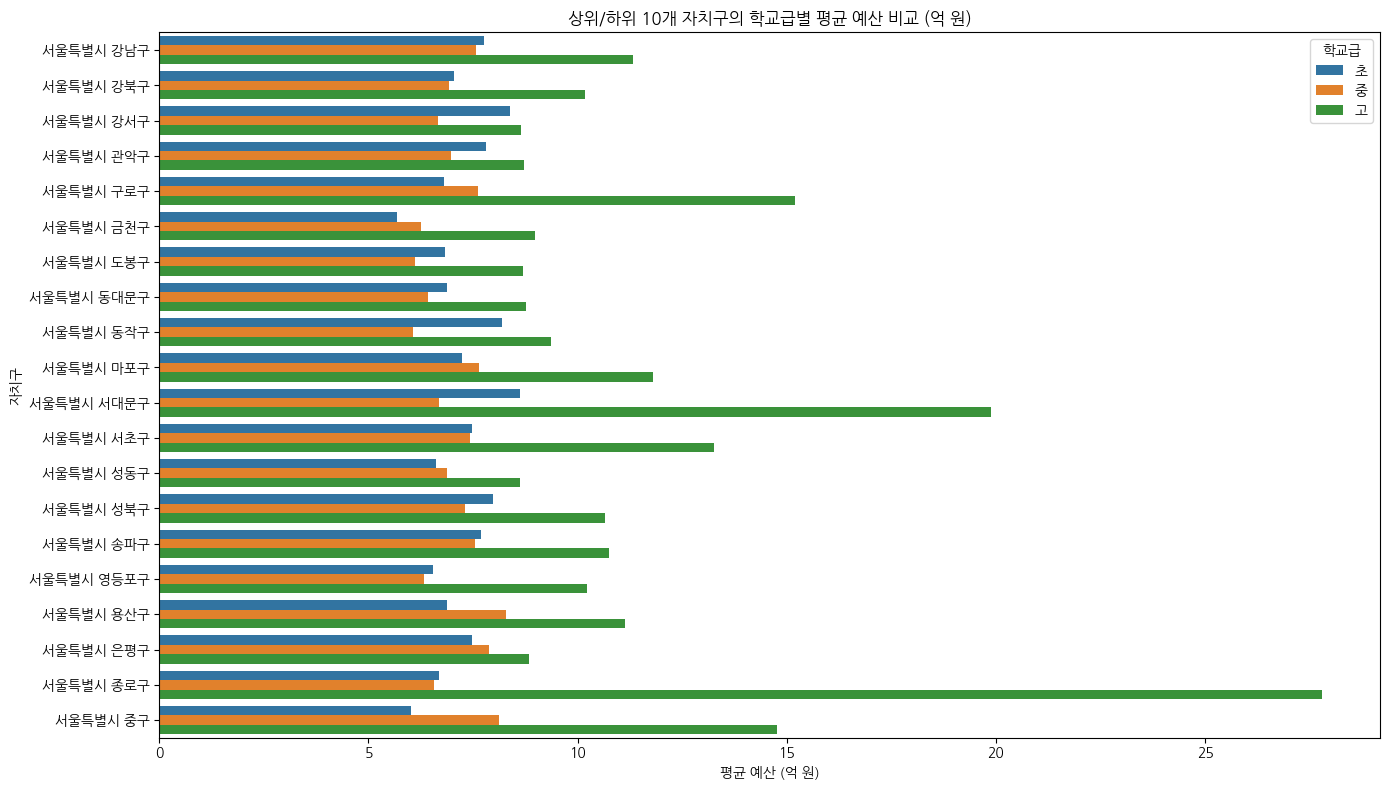

In [ ]:
import seaborn as sns

# 1. 자치구별 평균 예산 막대그래프
# 시각화용 데이터 정의
plot_data = grouped_result.copy()
plot_data = plot_data[plot_data['학교과정구분명(초-중-고)'].isin(['초', '중', '고'])]
plot_data['평균_전체세입_억'] = plot_data['평균_전체세입'] / 1e8

# 상위/하위 10개 자치구 추출
top_districts = plot_data.groupby('지역')['평균_전체세입_억'].mean().sort_values(ascending=False).head(10).index
bottom_districts = plot_data.groupby('지역')['평균_전체세입_억'].mean().sort_values(ascending=True).head(10).index
highlight_districts = top_districts.union(bottom_districts)
filtered_plot_data = plot_data[plot_data['지역'].isin(highlight_districts)]

#  시각화
plt.figure(figsize=(14, 8))
sns.barplot(
    data=filtered_plot_data,
    x='평균_전체세입_억',
    y='지역',
    hue='학교과정구분명(초-중-고)',
    hue_order=['초', '중', '고'],
    dodge=True
)
plt.title("상위/하위 10개 자치구의 학교급별 평균 예산 비교 (억 원)")
plt.xlabel("평균 예산 (억 원)")
plt.ylabel("자치구")
plt.legend(title="학교급")
plt.tight_layout()
plt.show()

In [ ]:
# 종로구 고등학교만 필터링
jongro_high = df_summary[
    (df_summary['지역'] == '서울특별시 종로구') &
    (df_summary['학교과정구분명(초-중-고)'] == '고')
]

# 억 단위 예산 확인
jongro_high['전체세입(억)'] = (jongro_high['전체세입'] / 1e8).round(2)
jongro_high[['학교명', '전체세입(억)', '자치구_학교급_평균예산']]

## 종로구 고등학교 데이터셋 문제 확인 필요!! api에서 잘못 긁어왔나,,?

NameError: name 'df_summary' is not defined

In [ ]:
df_check = df[df['지역'] == '서울특별시 종로구']
df_check[df_check['학교과정구분명(초-중-고)'] == '고']['학교명'].dropna().unique()


array(['서울과학고등학교', '경기상업고등학교'], dtype=object)

In [ ]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 2. 예산 비교용 컬럼 정리
df_compare = df[['지역', '학교명', '학교과정구분명(초-중-고)', '전체세입']].dropna()

# 3. 자치구+학교급별 평균 예산 계산
mean_by_district_level = df_compare.groupby(
    ['지역', '학교과정구분명(초-중-고)']
)['전체세입'].mean().rename('자치구_학교급_평균예산')
df_compare = df_compare.merge(mean_by_district_level, on=['지역', '학교과정구분명(초-중-고)'])

# 4. 학교별 평균 세입 계산
df_summary = df_compare.groupby(
    ['지역', '학교명', '학교과정구분명(초-중-고)']
).agg({
    '전체세입': 'mean',
    '자치구_학교급_평균예산': 'first'
}).reset_index()

# 5. 차이 및 비교 결과 계산
df_summary['차이(원)'] = df_summary['전체세입'] - df_summary['자치구_학교급_평균예산']
df_summary['차이(%)'] = (df_summary['차이(원)'] / df_summary['자치구_학교급_평균예산']) * 100
df_summary['비교결과'] = df_summary.apply(
    lambda row: '평균 초과' if row['전체세입'] > row['자치구_학교급_평균예산'] else '평균 미만',
    axis=1
)

# 💡 여기서 억 단위 컬럼 직접 계산 추가
df_summary['전체세입(억)'] = round(df_summary['전체세입'] / 1e8, 2)
df_summary['자치구_학교급_평균예산(억)'] = round(df_summary['자치구_학교급_평균예산'] / 1e8, 2)
df_summary['차이(원)(억)'] = round(df_summary['차이(원)'] / 1e8, 2)

# 6. 차이 비율 기준 상위/하위 학교 추출
top_over_funded = df_summary.sort_values('차이(%)', ascending=False).head(10)
top_under_funded = df_summary.sort_values('차이(%)', ascending=True).head(10)

# 7. 통합 결과 정리
extreme_funding = pd.concat([
    top_over_funded.assign(분류='가장 많이 받은 학교'),
    top_under_funded.assign(분류='가장 적게 받은 학교')
])

# 8. 결과 확인
columns_to_show = [
    '지역', '학교명', '학교과정구분명(초-중-고)',
    '전체세입(억)', '자치구_학교급_평균예산(억)', '차이(원)(억)', '차이(%)', '비교결과', '분류'
]
print(extreme_funding[columns_to_show])


             지역            학교명 학교과정구분명(초-중-고)  전체세입(억)  자치구_학교급_평균예산(억)  \
102   서울특별시 강서구       서울공진초등학교              초    19.06             8.38   
196   서울특별시 구로구       세종과학고등학교              고    32.39            15.20   
365   서울특별시 서초구         서울고등학교              고    26.01            13.25   
473   서울특별시 송파구         해누리중학교              중    14.63             7.54   
9     서울특별시 강남구       서울개원초등학교              초    14.70             7.77   
247   서울특별시 노원구       서울한천초등학교              초    12.01             6.45   
215   서울특별시 노원구     경기기계공업고등학교              고    21.73            11.93   
393   서울특별시 성동구          광희중학교              중    11.98             6.87   
384   서울특별시 서초구       서울잠원초등학교              초    12.98             7.47   
319   서울특별시 동작구       서울신길초등학교              초    14.14             8.20   
61    서울특별시 강동구       서울둔촌초등학교              초     0.00             7.52   
67    서울특별시 강동구       서울위례초등학교              초     0.00             7.52   
56    서울특별시 강동구       서울강

<ipython-input-10-dbdfa880e491>:4: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("서울시_국공립_통합데이터셋.csv")


📊가장 많이 받은 학교들 (예: 평균 대비 2배 이상)

| 학교명      | 자치구 | 차이(%)   |
| -------- | --- | ------- |
| 서울공진초등학교 | 강서구 | +127.4% |
| 세종과학고등학교 | 구로구 | +113.1% |
| 서울고등학교   | 서초구 | +96.3%  |

→ 과학고, 특목고들이 포함되어 있음

→ 특정 목적(연구, 과학실 확충 등)으로 별도 지원 가능성

📊가장 적게 받은 학교들 (예: -40% 이하)

→ 이런 학교들은 같은 자치구, 같은 급의 평균보다 훨씬 적은 예산을 받고 있음
→ 구조적 소외 가능성, 개선 정책 필요

In [ ]:
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 2. 필요한 컬럼 정리 및 결측 제거
df_compare = df[['지역', '학교명', '학교과정구분명(초-중-고)', '전체세입']].dropna()

# 3. 자치구 + 학교급별 평균 예산 계산
mean_by_district_level = df_compare.groupby(['지역', '학교과정구분명(초-중-고)'])['전체세입'].mean().rename('자치구_학교급_평균예산')
df_compare = df_compare.merge(mean_by_district_level, on=['지역', '학교과정구분명(초-중-고)'])

# 4. 학교별 평균 계산
df_summary = df_compare.groupby(['지역', '학교명', '학교과정구분명(초-중-고)']).agg({
    '전체세입': 'mean',
    '자치구_학교급_평균예산': 'first'
}).reset_index()

# 5. 차이 및 비교 결과 계산
df_summary['차이(원)'] = df_summary['전체세입'] - df_summary['자치구_학교급_평균예산']
df_summary['차이(%)'] = (df_summary['차이(원)'] / df_summary['자치구_학교급_평균예산']) * 100
df_summary['비교결과'] = df_summary.apply(
    lambda row: '평균 초과' if row['전체세입'] > row['자치구_학교급_평균예산'] else '평균 미만', axis=1
)

# 6. 자치구별 평균 대비 예산 가장 많이 받은 학교
top_by_district = df_summary.sort_values(['지역', '차이(%)'], ascending=[True, False]).groupby('지역').head(1)
top_by_district = top_by_district.assign(분류='자치구 내 예산 가장 많이 받은 학교')

# 7. 자치구별 평균 대비 예산 가장 적게 받은 학교
bottom_by_district = df_summary.sort_values(['지역', '차이(%)'], ascending=[True, True]).groupby('지역').head(1)
bottom_by_district = bottom_by_district.assign(분류='자치구 내 예산 가장 적게 받은 학교')

# 8. 통합
extreme_by_district = pd.concat([top_by_district, bottom_by_district])

# 9. 억 단위로 계산된 컬럼 추가
extreme_by_district['전체세입(억)'] = round(extreme_by_district['전체세입'] / 1e8, 2)
extreme_by_district['자치구_학교급_평균예산(억)'] = round(extreme_by_district['자치구_학교급_평균예산'] / 1e8, 2)
extreme_by_district['차이(원)(억)'] = round(extreme_by_district['차이(원)'] / 1e8, 2)

# 10. 결과 컬럼 선택
cols_to_show = [
    '지역', '학교명', '학교과정구분명(초-중-고)',
    '전체세입(억)', '자치구_학교급_평균예산(억)', '차이(원)(억)', '차이(%)', '비교결과', '분류'
]

# 11. 결과 출력
print(extreme_by_district[cols_to_show].head(10))



            지역       학교명 학교과정구분명(초-중-고)  전체세입(억)  자치구_학교급_평균예산(억)  차이(원)(억)  \
9    서울특별시 강남구  서울개원초등학교              초    14.70             7.77      6.94   
58   서울특별시 강동구  서울고일초등학교              초    12.82             7.52      5.29   
80   서울특별시 강북구    삼각산중학교              중     8.60             6.93      1.66   
102  서울특별시 강서구  서울공진초등학교              초    19.06             8.38     10.68   
146  서울특별시 관악구  서울인헌초등학교              초     9.57             7.81      1.76   
161  서울특별시 광진구  서울동자초등학교              초     9.93             6.97      2.96   
196  서울특별시 구로구  세종과학고등학교              고    32.39            15.20     17.19   
209  서울특별시 금천구  서울시흥초등학교              초     7.23             5.68      1.55   
247  서울특별시 노원구  서울한천초등학교              초    12.01             6.45      5.56   
275  서울특별시 도봉구  서울창림초등학교              초     8.71             6.82      1.89   

          차이(%)   비교결과                    분류  
9     89.330553  평균 초과  자치구 내 예산 가장 많이 받은 학교  
58    70.327305  평균 초과  자치구 내 예산 가장 

<ipython-input-11-eb9ac7de1212>:4: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("서울시_국공립_통합데이터셋.csv")


<ipython-input-12-25e622f0e002>:7: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("서울시_국공립_통합데이터셋.csv")


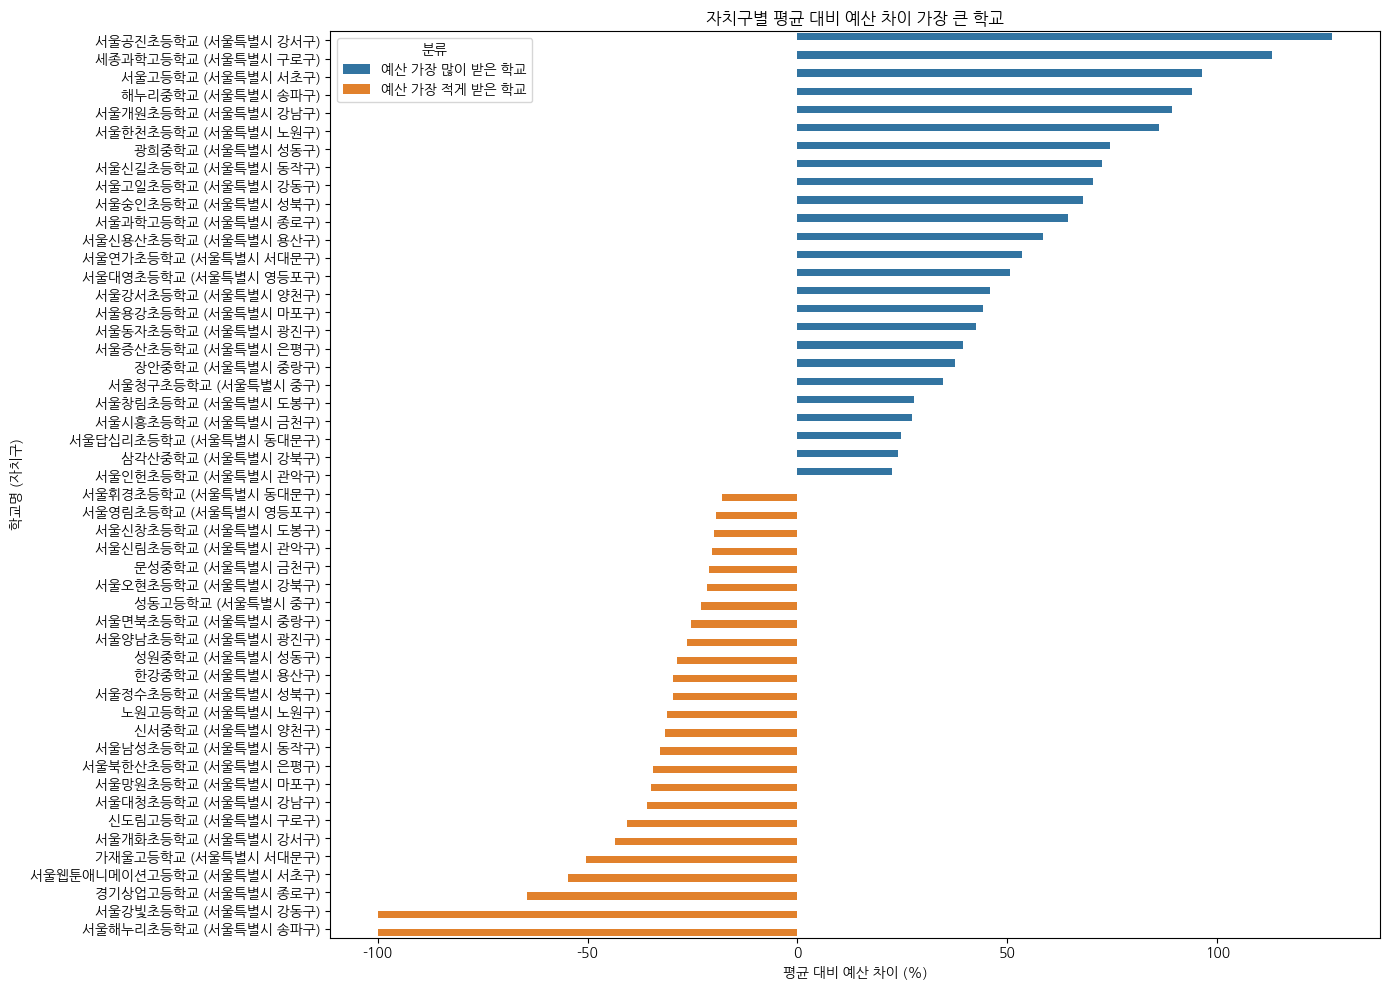

In [ ]:
# 자치구별 상하위 예산 학교 1곳씩 + 자치구명 포함 바 차트 시각화 코드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기 및 정리
df = pd.read_csv("서울시_국공립_통합데이터셋.csv")
df_compare = df[['지역', '학교명', '학교과정구분명(초-중-고)', '전체세입']].dropna()

# 2. 자치구+학교급별 평균 예산 계산
mean_by_district_level = df_compare.groupby(['지역', '학교과정구분명(초-중-고)'])['전체세입'].mean().rename('자치구_학교급_평균예산')
df_compare = df_compare.merge(mean_by_district_level, on=['지역', '학교과정구분명(초-중-고)'])

# 3. 학교별 평균 예산 비교
df_summary = df_compare.groupby(['지역', '학교명', '학교과정구분명(초-중-고)']).agg({
    '전체세입': 'mean',
    '자치구_학교급_평균예산': 'first'
}).reset_index()

df_summary['차이(원)'] = df_summary['전체세입'] - df_summary['자치구_학교급_평균예산']
df_summary['차이(%)'] = (df_summary['차이(원)'] / df_summary['자치구_학교급_평균예산']) * 100
df_summary['비교결과'] = df_summary.apply(
    lambda row: '평균 초과' if row['전체세입'] > row['자치구_학교급_평균예산'] else '평균 미만',
    axis=1
)

# 4. 자치구별 상위/하위 1개 학교 추출
top1_by_district = df_summary.sort_values(['지역', '차이(%)'], ascending=[True, False]).groupby('지역').head(1)
top1_by_district = top1_by_district.assign(분류='예산 가장 많이 받은 학교')

bottom1_by_district = df_summary.sort_values(['지역', '차이(%)'], ascending=[True, True]).groupby('지역').head(1)
bottom1_by_district = bottom1_by_district.assign(분류='예산 가장 적게 받은 학교')

# 5. 통합 및 시각화용 정렬
extreme_by_district = pd.concat([top1_by_district, bottom1_by_district])
extreme_by_district_sorted = extreme_by_district.sort_values('차이(%)', ascending=False)

# 6. 자치구 포함 학교명 생성
extreme_by_district_sorted['학교명_자치구'] = extreme_by_district_sorted['학교명'] + ' (' + extreme_by_district_sorted['지역'] + ')'

# 7. 바 차트 시각화
plt.figure(figsize=(14, 10))
sns.barplot(
    data=extreme_by_district_sorted,
    x='차이(%)',
    y='학교명_자치구',
    hue='분류',
    dodge=True
)
plt.title("자치구별 평균 대비 예산 차이 가장 큰 학교")
plt.xlabel("평균 대비 예산 차이 (%)")
plt.ylabel("학교명 (자치구)")
plt.legend(title="분류")
plt.tight_layout()
plt.show()

### 학교 재정 위험도 클러스터링 및 지도 시각화




In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 클러스터링 대상 컬럼 선택 및 중복 제거
cluster_cols = ["학교명", "정보공시 학교코드", "정부이전의존도(%)", "전체세입", "1인당예산", "발전기금_총액"]
df_cluster = df_merged[cluster_cols].drop_duplicates(subset=["학교명", "정보공시 학교코드"]).copy()

# 수치형으로 변환 및 결측 제거
numeric_cols = ["정부이전의존도(%)", "전체세입", "1인당예산", "발전기금_총액"]
df_cluster[numeric_cols] = df_cluster[numeric_cols].apply(pd.to_numeric, errors='coerce')
df_cluster_clean = df_cluster.dropna(subset=numeric_cols)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_clean[numeric_cols])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster_clean["재정위험군"] = kmeans.fit_predict(X_scaled)

# 정부의존도 기준으로 클러스터 위험도 재정의
centers = kmeans.cluster_centers_
risk_order = np.argsort(-centers[:, 0])  # 정부의존도 기준 정렬
reorder_map = {old: new for new, old in enumerate(risk_order)}
df_cluster_clean["재정위험군(재지정)"] = df_cluster_clean["재정위험군"].map(reorder_map)

# 군집별 통계 요약
cluster_summary = df_cluster_clean.groupby("재정위험군(재지정)")[numeric_cols].mean().round(0)
cluster_summary["학교 수"] = df_cluster_clean["재정위험군(재지정)"].value_counts().sort_index()

# 최종 결과
df_cluster_result = df_cluster_clean[["학교명", "정보공시 학교코드", "재정위험군(재지정)"] + numeric_cols]


<ipython-input-13-d5a58db877ec>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_clean["재정위험군"] = kmeans.fit_predict(X_scaled)
<ipython-input-13-d5a58db877ec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_clean["재정위험군(재지정)"] = df_cluster_clean["재정위험군"].map(reorder_map)


In [ ]:
# CSV 저장
df_cluster_result.to_csv("학교별_재정위험클러스터링결과.csv", index=False, encoding="utf-8-sig")
cluster_summary.to_csv("재정위험_군집요약.csv", encoding="utf-8-sig")

In [ ]:
!pip install folium ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame

# 1. 클러스터링 결과 불러오기 (또는 앞선 과정에서 생성된 df_cluster_result 사용)
# df_cluster_result = pd.read_csv("학교별_재정위험클러스터링결과.csv")

# 2. 원본 데이터에서 학교명, 위도, 경도 가져오기
df_merged = pd.read_csv("서울시_국공립_통합데이터셋.csv")
location_df = df_merged[["학교명", "위도", "경도"]].drop_duplicates(subset=["학교명"])

# 3. 클러스터 결과와 위치 정보 병합
df_cluster_map = pd.merge(df_cluster_result, location_df, on="학교명", how="left")
df_cluster_map = df_cluster_map.dropna(subset=["위도", "경도"])

### ✅서울 지역만 필터링 ###
df_cluster_map = df_cluster_map[
    (df_cluster_map['위도'] >= 37.4) & (df_cluster_map['위도'] <= 37.7) &
    (df_cluster_map['경도'] >= 126.8) & (df_cluster_map['경도'] <= 127.2)
]

# 4. 색상 지정
color_dict = {
    0: "red",     # 위험
    1: "orange",  # 주의
    2: "green"    # 안정
}

# 5. 지도 생성
seoul_center = [37.5665, 126.9780]
school_map = folium.Map(location=seoul_center, zoom_start=11)
marker_cluster = MarkerCluster().add_to(school_map)

# 6. 마커 추가
for _, row in df_cluster_map.iterrows():
    danger_level = row["재정위험군(재지정)"]
    color = color_dict.get(danger_level, "gray")
    popup_text = f"""<b>학교명:</b> {row['학교명']}<br>
                     <b>재정위험군:</b> {danger_level}<br>
                     <b>정부이전의존도:</b> {row['정부이전의존도(%)']:.2f}%<br>
                     <b>1인당예산:</b> {row['1인당예산']:.0f}"""
    folium.Marker(
        location=[row["위도"], row["경도"]],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color=color, icon="info-sign")
    ).add_to(marker_cluster)

# 7. HTML로 저장
school_map.save("재정위험_학교_지도_클러스터링.html")

# 8. 코랩에서 바로 확인
IFrame("재정위험_학교_지도_클러스터링.html", width='100%', height=600)


<ipython-input-17-fe1598b1d187>:10: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("서울시_국공립_통합데이터셋.csv")


In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame

# 1. 서울시 국공립 통합 데이터 불러오기
df = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 2. 필요한 컬럼 추출 및 중복 제거
df = df[["학교명", "위도", "경도"]].drop_duplicates(subset=["학교명"])
df = df.dropna(subset=["위도", "경도"])

# 3. 서울시 범위 내 위경도 필터링
df = df[
    (df["위도"] >= 37.4) & (df["위도"] <= 37.7) &
    (df["경도"] >= 126.8) & (df["경도"] <= 127.2)
]

# 4. 지도 생성
seoul_center = [37.5665, 126.9780]
school_map = folium.Map(location=seoul_center, zoom_start=11)
marker_cluster = MarkerCluster().add_to(school_map)

# 5. 마커 추가 (학교명만 표시)
for _, row in df.iterrows():
    popup_text = f"<b>학교명:</b> {row['학교명']}"
    folium.Marker(
        location=[row["위도"], row["경도"]],
        popup=folium.Popup(popup_text, max_width=250),
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(marker_cluster)

# 6. HTML로 저장
school_map.save("서울시_학교명_지도.html")

# 7. 코랩에서 바로 확인
IFrame("서울시_학교명_지도.html", width='100%', height=600)


<ipython-input-18-53c5a4bf4790>:7: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("서울시_국공립_통합데이터셋.csv")


### 예산안 시뮬레이션 - 건물 자체 건축/유지 관련 항목

In [ ]:
# 1. 필요한 패키지 임포트
import pandas as pd

# 2. 데이터 불러오기
df_merged = pd.read_csv("서울시_국공립_통합데이터셋.csv")

# 3. 전체세입 및 정부이전의존도 계산
df_merged["전체세입"] = df_merged[[
    "정부이전수입/인적자원운용",
    "기타이전수입/학생복지_교육격차해소",
    "학부모부담수입/기본적교육활동",
    "지원금수입/선택적교육활동",
    "행정활동수입/교육활동지원",
    "기타/학교일반운영"
]].sum(axis=1)

df_merged["정부이전의존도"] = df_merged["정부이전수입/인적자원운용"] / (df_merged["전체세입"] + 1e-9)

# 4. 자치구별 정부의존도 평균 계산
district_avg = df_merged.drop_duplicates(subset=["학교명", "정보공시 학교코드"])\
                        .groupby("지역")["정부이전의존도"].mean().reset_index()
district_avg["자치구"] = district_avg["지역"].str.replace("서울특별시 ", "", regex=False)

# 5. 총 예산 가정 (단위: '원')
total_budget = 100_000_000_000  # 1,000억 원 (원 단위)

# 6. 자치구별 배정 예산 계산 (정부의존도 비율 기반) :정부이전 의존도가 높을수록 예산을 더 많이 배정(가중치)
district_avg["정부이전의존도비율"] = district_avg["정부이전의존도"] / district_avg["정부이전의존도"].sum()
district_avg["배정예산(원)"] = (district_avg["정부이전의존도비율"] * total_budget).round(0).astype(int)

# 7. 항목별 예산 비중 (전국 예산안 기준)
expense_weights = {
    "화장실개선": 0.5086,
    "전기시설개선(수배전)": 0.2057,
    "전기시설개선(방송장비)": 0.0035,
    "냉난방개선": 0.0040,
    "창호개선": 0.0941,
    "외벽개선": 0.0821,
    "소방시설개선": 0.0110,
    "방수공사": 0.0267,
    "바닥개선": 0.0624,
    "도장공사": 0.0296,
    "외부환경개선": 0.0281,
    "급식시설개선": 0.0343
}

# 8. 항목별 예산 배정 (원 단위)
for item, ratio in expense_weights.items():
    district_avg[f"{item}_예산(원)"] = (district_avg["배정예산(원)"] * ratio).round(0).astype(int)

# 9. 건물 유지 관련 항목만 추출
building_related_items = [
    "화장실개선", "창호개선", "외벽개선",
    "방수공사", "바닥개선", "도장공사", "외부환경개선"
]

# 10. 건물 유지 예산 합계 및 비율 계산
cols = ["자치구", "배정예산(원)"] + [f"{item}_예산(원)" for item in building_related_items]
district_building = district_avg[cols].copy()

district_building["건물유지관련_예산합계(원)"] = district_building[
    [f"{item}_예산(원)" for item in building_related_items]
].sum(axis=1)

district_building["건물유지_비율(%)"] = (
    district_building["건물유지관련_예산합계(원)"] / district_building["배정예산(원)"] * 100
).round(2)

# 11. 결과 미리보기
print(district_building.sort_values(by="배정예산(원)", ascending=False))


     자치구     배정예산(원)  화장실개선_예산(원)  창호개선_예산(원)  외벽개선_예산(원)  방수공사_예산(원)  \
21   은평구  4222188268   2147404953   397307916   346641657   112732427   
8    노원구  4192353947   2132231217   394500506   344192259   111935850   
9    도봉구  4164907868   2118272142   391917830   341938936   111203040   
7    금천구  4154787657   2113125002   390965519   341108067   110932830   
19  영등포구  4129241348   2100132150   388561611   339010715   110250744   
1    강동구  4092379490   2081384209   385092910   335984356   109266532   
20   용산구  4068583478   2069281557   382853705   334030704   108631179   
2    강북구  4056852933   2063315402   381749861   333067626   108317973   
6    구로구  4054102658   2061916612   381491060   332841828   108244541   
10  동대문구  4047923967   2058774130   380909645   332334558   108079570   
14   서초구  4033479962   2051427909   379550464   331148705   107693915   
5    광진구  4019154209   2044141831   378202411   329972561   107311417   
15   성동구  4000432338   2034619887   376440683   328

<ipython-input-81-499a6b30e970>:5: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv("서울시_국공립_통합데이터셋.csv")


In [ ]:
#2. 자치구별 정부이전의존도 및 예산 요약 테이블 생성
gov_budget_summary = district_avg[["자치구", "정부이전의존도", "정부이전의존도비율", "배정예산(원)"]].copy()

# 3. 보기 좋게 반올림
gov_budget_summary["정부이전의존도"] = gov_budget_summary["정부이전의존도"].round(4)
gov_budget_summary["정부이전의존도비율"] = (gov_budget_summary["정부이전의존도비율"] * 100).round(2)  # 퍼센트화

# 4. 예산 많은 순서로 정렬
gov_budget_summary = gov_budget_summary.sort_values(by="배정예산(원)", ascending=False)

# 5. 결과 출력
print(gov_budget_summary)


     자치구  정부이전의존도  정부이전의존도비율     배정예산(원)
21   은평구   0.9324       4.22  4222188268
8    노원구   0.9258       4.19  4192353947
9    도봉구   0.9198       4.16  4164907868
7    금천구   0.9175       4.15  4154787657
19  영등포구   0.9119       4.13  4129241348
1    강동구   0.9038       4.09  4092379490
20   용산구   0.8985       4.07  4068583478
2    강북구   0.8959       4.06  4056852933
6    구로구   0.8953       4.05  4054102658
10  동대문구   0.8939       4.05  4047923967
14   서초구   0.8907       4.03  4033479962
5    광진구   0.8876       4.02  4019154209
15   성동구   0.8835       4.00  4000432338
13  서대문구   0.8815       3.99  3991534880
4    관악구   0.8794       3.98  3982272983
22   종로구   0.8770       3.97  3971446538
16   성북구   0.8769       3.97  3970676385
18   양천구   0.8765       3.97  3969178693
11   동작구   0.8759       3.97  3966119568
12   마포구   0.8754       3.96  3963780325
17   송파구   0.8731       3.95  3953628111
24   중랑구   0.8667       3.92  3924542668
0    강남구   0.8354       3.78  3782950821
3    강서구   0.825

### 서울국공립_초중고_환경위생_통합점수 지도시각화

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from IPython.display import IFrame

# 1. 위치 데이터 불러오기
df_location = pd.read_csv("서울시_국공립_통합데이터셋.csv")
df_location = df_location[["학교명", "위도", "경도"]].drop_duplicates(subset=["학교명"])
df_location = df_location.dropna(subset=["위도", "경도"])

# 2. 환경위생 점수 데이터 불러오기
df_score = pd.read_csv("환경위생_통합점수_최종처리_개선(찐최종).csv")
df_grade = df_score.sort_values("공시년도", ascending=False).drop_duplicates(subset=["SCHUL_NM"])
df_grade = df_grade[["SCHUL_NM", "SAFETY_GRADE"]].rename(columns={"SCHUL_NM": "학교명"})

# 3. 병합
df_map = pd.merge(df_location, df_grade, on="학교명", how="inner")

# 4. 서울시 위경도 범위 필터링
df_map = df_map[
    (df_map["위도"] >= 37.4) & (df_map["위도"] <= 37.7) &
    (df_map["경도"] >= 126.8) & (df_map["경도"] <= 127.2)
]

# 5. GRADE별 색상 지정
grade_color = {
    "A": "green",     # 매우 안전
    "B": "blue",      # 양호
    "C": "orange",    # 보통
    "D": "red",       # 위험
    "E": "purple"     # 매우 위험
}
df_map["마커색"] = df_map["SAFETY_GRADE"].map(grade_color).fillna("gray")
# 6. 지도 생성
seoul_center = [37.5665, 126.9780]
school_map = folium.Map(location=seoul_center, zoom_start=11)
marker_cluster = MarkerCluster().add_to(school_map)

# 7. 마커 추가
for _, row in df_map.iterrows():
    popup_text = f"<b>학교명:</b> {row['학교명']}<br><b>SAFETY GRADE:</b> {row['SAFETY_GRADE']}"
    folium.Marker(
        location=[row["위도"], row["경도"]],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color=row["마커색"], icon="info-sign")
    ).add_to(marker_cluster)

# 8. 범례 HTML도 같이 수정
legend_html = """
<div style="
    position: fixed;
    bottom: 50px; left: 50px; width: 160px; height: 170px;
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white; padding:10px;
">
<b>환경위생 등급 범례</b><br>
🟢 A - 매우 안전<br>
🔵 B - 양호<br>
🟠 C - 보통<br>
🔴 D - 위험<br>
🟣 E - 매우 위험<br>
⚪ 회색 - 정보 없음
</div>
"""
school_map.get_root().html.add_child(folium.Element(legend_html))

# 9. 지도 저장 및 확인
school_map.save("서울시_환경위생등급_지도_ABCDE.html")
IFrame("서울시_환경위생등급_지도_ABCDE.html", width='100%', height=600)


<ipython-input-22-d8cc1181d943>:7: DtypeWarning: Columns (38,60,67,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv("서울시_국공립_통합데이터셋.csv")
